# Objective
Demonstrate recover of HR from BART Model

In [2]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines

In [2]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/simsurv_func.py'>

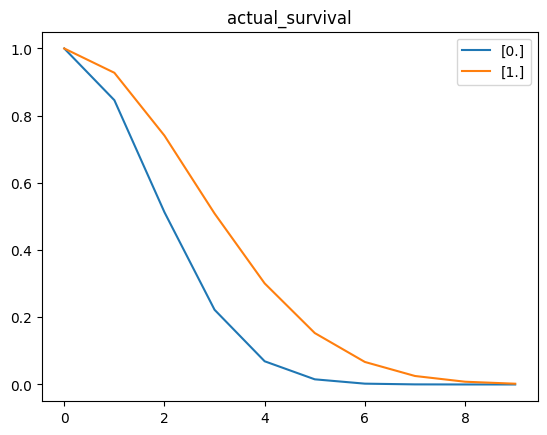

cens_calc: 0.0     
t_mean: 3.393     
t_max: 10.0
hazard rate 1 [0.      0.27027 0.54053 0.8108  1.08107]
hazard rate 0 [0.      0.60149 1.20298 1.80447 2.40596]
HR t-series = [       nan 0.44933415 0.44932584 0.44932861 0.44933   ]


/tmp/ipykernel_4867/4238106220.py:40: RuntimeWarning: invalid value encountered in divide
  HR_unique = hz_unique[1]/hz_unique[0]


In [3]:
OUTPUTS = "outputs"
ALPHA = 2
LAMBDA = "np.exp(-1 + -.4*x_mat[:,0])"
N = 1000
# T = 30
X_VARS = 1
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# get unique x_mat
x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]
hz_unique = np.round(hz_mat[x_unique[1],:],5) 

HR_unique = hz_unique[1]/hz_unique[0]
HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
print(f"hazard rate 1 {hz_unique[1][HR_times]}")
print(f"hazard rate 0 {hz_unique[0][HR_times]}")
print(f"HR t-series = {HR_unique[HR_times]}")

Hazard rate is calculated along with the survival.
The Hazard Ratio can be calculated from the hazard rates

The HR for a variable is exp(B) or calculated as the Hazard Rate[1]/Hazard Rate[0] where 1 and 0 are the values variable from X.

In [4]:

# lifelines
cphl = lifelines.CoxPHFitter()
cphl.fit(train, duration_col="time", event_col="status")
cphl.print_summary()
cphl_pred = cphl.predict_survival_function(pd.DataFrame(x_out, columns= ["X0"]))
cphl_pred.columns=["a", "b"]
cdhl_pred = pd.concat([pd.DataFrame([[1,1]], columns = ["a","b"]),cphl_pred], axis=0)



<lifelines.CoxPHFitter: fitted with 1000 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 1000
   partial log-likelihood = -5844.37
         time fit was run = 2023-08-31 19:24:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X0         -0.78       0.46       0.07            -0.91            -0.65                 0.40                 0.52

            cmp to      z      p   -log2(p)
covariate                                  
X0            0.00 -11.68 <0.005     102.26
---
Concordance = 0.62
Partial AIC = 11690.74
log-likelihood ratio test = 135.51 on 1 df
-log2(p) of ll-ratio test = 101.63

Text(8.0, 0.4, 'True Ave HR 0.45')

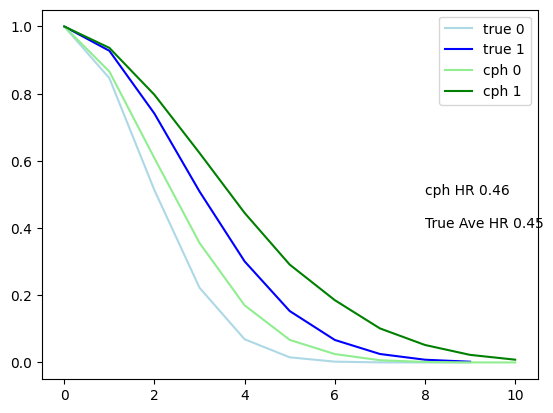

In [5]:
# plot
plt.plot(np.arange(0,T,1), sv_unique[0], color= "lightblue", label="true 0")
plt.plot(np.arange(0,T,1), sv_unique[1], color = "blue", label="true 1")
plt.plot(cdhl_pred.index, cdhl_pred["a"], label = "cph 0", color="lightgreen")
plt.plot(cdhl_pred.index, cdhl_pred["b"], label = "cph 1", color = "green")
plt.legend()

# get cphl HR
cphl_expco = cphl.summary["exp(coef)"]
plt.text(T-T/5,.5,f"cph HR {np.round(cphl_expco[0],2)}")


# get TRUE HR
hz_unique = hz_mat[x_unique[1],:]
true_HR = np.round(hz_unique[1].mean()/hz_unique[0].mean(),2)
plt.text(T-T/5,.4, f"True Ave HR {true_HR}")



Text(0.5, 1.0, 'Cumulative Hist')

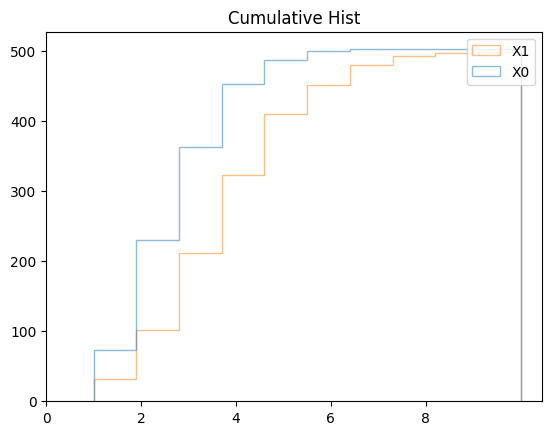

In [6]:
x0 = train[train["X0"] == 0]
x1 = train[train["X0"] == 1]
hist_lst = [x0["time"], x1["time"]]

plt.hist(hist_lst, alpha=0.5, bins = T, histtype="step", cumulative=True, label= ["X0", "X1"])
# plt.hist(x0["time"], alpha=0.5, bins= T, label = "X=0", histtype="step")
# plt.hist(x1["time"], alpha=0.5, bins = T, label= "X=1", histtype="step")
plt.xticks(np.arange(0,T, 2))
plt.legend()
plt.title("Cumulative Hist")

In [7]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 4

y_sk = ssf.get_y_sklearn(status, t_event)
x_sk = train.iloc[:,2:]


# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))
# model bart

with pm.Model() as bart:
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M)
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

with bart:
# pm.set_data({"x":pd.DataFrame(test_x), "off":off_test})
    pm.set_data({"x":pd.DataFrame(b_te_x)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_out)
# bart_svt
bart_sv_t = np.unique(b_tr_t)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]


Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 133 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


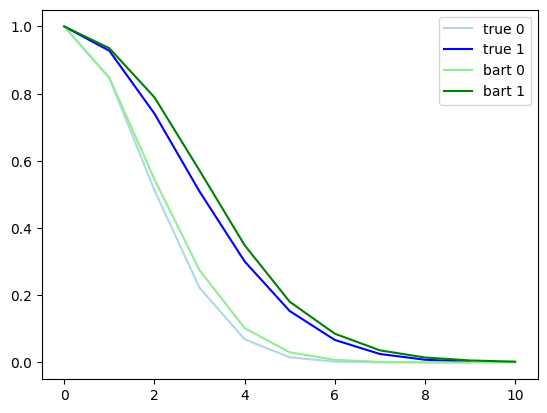

In [11]:
plt.plot(np.arange(0,T,1), sv_unique[0], color= "lightblue", label="true 0")
plt.plot(np.arange(0,T,1), sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")
plt.legend()

Hazard Ratios,
In the tails of the distribution the hazards can be too small or large where the prcesion of hazards ratios expand aggressively. We can apply some adhoc analyses to select time points within the major movement of the distribution and calculate the hazard ratio.

Below we can see that using this approach the mean HR approximates the true and CPH calculate HR

In [12]:
pp_shape = pp.posterior_predictive.mu.values.shape

mu = pp.posterior_predictive.mu.values.reshape(pp_shape[0]*pp_shape[1], pp_shape[2]).mean(0).reshape(2,int(pp_shape[2]/2))

print(mu)

print(f"hazard ratio all: {(mu[1]/mu[0]).mean()}")
hrt = 1
hrt2 = 1
print(f"mean hazard ratio in key timepoines: {(mu[1][hrt:-hrt2]/mu[0][hrt:-hrt2]).mean()}")
print(f"hazard ratio in key timepoines: {(mu[1][hrt:-hrt2]/mu[0][hrt:-hrt2])}")

print(f"hazard rate 1 {hz_unique[1][hrt:-hrt2]}")
print(f"hazard rate 0 {hz_unique[0][hrt:-hrt2]}")
print(f"HR t-series = {HR_unique[hrt:-hrt2]}")

[[0.15212846 0.35703635 0.49586615 0.6281021  0.70409975 0.73907902
  0.7724754  0.7817326  0.78424383 0.78214941]
 [0.06480415 0.156069   0.27609877 0.38919531 0.48211118 0.52610585
  0.5782337  0.59117556 0.59635814 0.59398897]]
hazard ratio all: 0.6460744366939226
mean hazard ratio in key timepoines: 0.659416215593512
hazard ratio in key timepoines: [0.43712355 0.55680099 0.61963702 0.68472    0.71183978 0.74854642
 0.75623757 0.7604244 ]
hazard rate 1 [0.13513347 0.27026695 0.40540042 0.54053389 0.67566736 0.81080084
 0.94593431 1.08106778]
hazard rate 0 [0.30074507 0.60149015 0.90223522 1.2029803  1.50372537 1.80447044
 2.10521552 2.40596059]
HR t-series = [0.44931006 0.44933415 0.44932612 0.44932584 0.44932933 0.44932861
 0.44932596 0.44933   ]


# C-index

In [152]:
# c.est <- (1-post$prob.test[ , 1])-(1-post$prob.test[ , 26])
# for(j in 2:K)
#    c.est <- c.est+((1-post$prob.test[ , j])-(1-post$prob.test[ , j+K]))*post$surv.test[ , j-1]*post$surv.test[ , j-1+K]
#c.est <- 0.5*(1-c.est)

# o.5 * (1-SUM_1_T(
#               ((1-p1_j) - (1_p2_j)) * S(p1_j-1) * S(p2_j-1)
# ))

S1 = bart_sv_val[1]
S2 = bart_sv_val[0]
q1 = 1-mu[1]
q2 = 1-mu[0]

c = np.zeros(q1.shape[0])
for i,idx in enumerate(np.arange(0,q1.shape[0],1)):
    if i == 0:
        c[i] = q1[i] - q2[i]
    else:
        c[i] = (q1[i] - q2[i]) * S1[i-1] * S2[i-1]

0.5 * (1-c.sum())




0.25787968606172496

In [151]:
# lifelines.utils.concordance_index()
# bart_sv_val

# lifelines.utils.concordance_index(bart_sv_t, cphl.predict_survival_function(pd.DataFrame(x_out, columns= ["X0"])))

cph_t = np.concatenate([cphl_pred.index, cphl_pred.index])
cph_S = np.concatenate([cphl_pred["a"], cphl_pred["b"]])
lifelines.utils.concordance_index(cph_t, cph_S)



0.06111111111111111

In [162]:
# b_t = np.concatenate([, bart_sv_t])
# b_S = np.concatenate([S1, S2])


tmp = np.zeros((x_sk["X0"].shape[0],2))

tmp[:,0] = y_sk["Survival_in_days"]
tmp[:,1] = x_sk["X0"]


at = 10
tmp[tmp[:,1] == 0,1] = bart_sv_val[0][at]
tmp[tmp[:,1] == 1,1] = bart_sv_val[1][at]

print(tmp)
lifelines.utils.concordance_index(tmp[:,0], tmp[:,1])

[[5. 0.]
 [4. 0.]
 [2. 0.]
 ...
 [3. 1.]
 [3. 1.]
 [3. 1.]]
[[5.00000000e+00 1.35862273e-04]
 [4.00000000e+00 1.35862273e-04]
 [2.00000000e+00 1.35862273e-04]
 ...
 [3.00000000e+00 3.86859136e-03]
 [3.00000000e+00 3.86859136e-03]
 [3.00000000e+00 3.86859136e-03]]


0.5960848386195503